# Image Segmentation Model

##### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from skimage.io import imread, imsave, imshow
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import OrderedDict
import datetime
torch.manual_seed(0)

##### Hyperparameters

In [2]:
batch_size = 4
learning_rate = 0.005
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### Dataset Creation

In [3]:
# class CellDataset(Dataset):
#     def __init__(self, data_dir):
#         self.data_dir = data_dir
#         self.image_dir = os.path.join(data_dir, 'image')
#         self.mask_dir = os.path.join(data_dir, 'mask')
#         self.image_files = os.listdir(self.image_dir)
#         self.mask_files = os.listdir(self.mask_dir)
#         self.transform = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip()
#         ])

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, index):
#         image_path = os.path.join(self.image_dir, self.image_files[index])
#         mask_path = os.path.join(self.mask_dir, self.mask_files[index])

#         image = imread(image_path)
#         mask = imread(mask_path)

#         image = torch.from_numpy(np.array(image)).permute(1, 2, 0).float()
#         mask = torch.from_numpy(np.array(mask)).unsqueeze(0).permute(1, 2, 0).float()
        
#         if self.transform:
#             image = self.transform(image)
#             mask = self.transform(mask)
#         print(mask_path)
#         return image, mask

In [4]:
class CellDataset(Dataset):
    def __init__(self, data_dir, train=True):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'image')
        self.mask_dir = os.path.join(data_dir, 'mask')
        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform_list = [
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1),
        ]

        if train:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
        else:
            self.image_files, self.test_image_files, self.mask_files, self.test_mask_files = train_test_split(
                self.image_files, self.mask_files, test_size=0.2, random_state=42)
            self.image_files, self.test_image_files = self.test_image_files, self.image_files
            self.mask_files, self.test_mask_files = self.test_mask_files, self.mask_files
        
        self.temp_image_file = []
        self.temp_mask_file = []
        
        for image_path, mask_path in zip(self.image_files, self.mask_files):
            image_path = os.path.join(self.image_dir, image_path)
            mask_path = os.path.join(self.mask_dir, mask_path)
            image = torch.tensor(imread(image_path))
            mask = torch.tensor(imread(mask_path))
            self.temp_image_file.append(image)
            self.temp_mask_file.append(mask)
            for transform in self.transform_list:
                self.temp_image_file.append(transform(image))
                self.temp_mask_file.append(transform(mask))
        
        self.image_files, self.mask_files = self.temp_image_file, self.temp_mask_file

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image = self.image_files[index].float()
        mask = torch.where(self.mask_files[index].unsqueeze(0).float() == 0, 0.0, 1.0)

        return image, mask


In [5]:
DATA_DIR = r"D:\multiplexed-immunofluorescence-instance-segmentation\data\final"
train_dataset = CellDataset(DATA_DIR)
test_dataset = CellDataset(DATA_DIR, train=False)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

##### Model Definition - UNet

In [7]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()

#         self.encoder1 = self.conv_block(in_channels, 64)
#         self.encoder2 = self.conv_block(64, 128)
#         self.encoder3 = self.conv_block(128, 256)
#         self.encoder4 = self.conv_block(256, 512)

#         self.decoder4 = self.conv_block(512 + 256, 256)
#         self.decoder3 = self.conv_block(256 + 128, 128)
#         self.decoder2 = self.conv_block(128 + 64, 64)
#         self.decoder1 = self.conv_block(64, out_channels)

#         self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         x1 = self.encoder1(x)
#         x2 = self.encoder2(nn.functional.max_pool2d(x1, kernel_size=2, stride=2))
#         x3 = self.encoder3(nn.functional.max_pool2d(x2, kernel_size=2, stride=2))
#         x4 = self.encoder4(nn.functional.max_pool2d(x3, kernel_size=2, stride=2))

#         x = self.upsample(x4)
#         x = torch.cat([x, x3], dim=1)
#         x = self.decoder4(x)

#         x = self.upsample(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.decoder3(x)

#         x = self.upsample(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.decoder2(x)

#         x = self.upsample(x)
#         x = self.decoder1(x)

#         return x

In [8]:
# class UNet(nn.Module):

#     def __init__(self, in_channels=3, out_channels=1, init_features=32):
#         super(UNet, self).__init__()

#         features = init_features
#         self.encoder1 = UNet._block(in_channels, features, name="enc1")
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder2 = UNet._block(features, features * 2, name="enc2")
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

#         self.upconv4 = nn.ConvTranspose2d(
#             features * 16, features * 8, kernel_size=2, stride=2
#         )
#         self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
#         self.upconv3 = nn.ConvTranspose2d(
#             features * 8, features * 4, kernel_size=2, stride=2
#         )
#         self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
#         self.upconv2 = nn.ConvTranspose2d(
#             features * 4, features * 2, kernel_size=2, stride=2
#         )
#         self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
#         self.upconv1 = nn.ConvTranspose2d(
#             features * 2, features, kernel_size=2, stride=2
#         )
#         self.decoder1 = UNet._block(features * 2, features, name="dec1")

#         self.conv = nn.Conv2d(
#             in_channels=features, out_channels=out_channels, kernel_size=1
#         )

#     def forward(self, x):
#         enc1 = self.encoder1(x)
#         enc2 = self.encoder2(self.pool1(enc1))
#         enc3 = self.encoder3(self.pool2(enc2))
#         enc4 = self.encoder4(self.pool3(enc3))

#         bottleneck = self.bottleneck(self.pool4(enc4))

#         dec4 = self.upconv4(bottleneck)
#         dec4 = torch.cat((dec4, enc4), dim=1)
#         dec4 = self.decoder4(dec4)
#         dec3 = self.upconv3(dec4)
#         dec3 = torch.cat((dec3, enc3), dim=1)
#         dec3 = self.decoder3(dec3)
#         dec2 = self.upconv2(dec3)
#         dec2 = torch.cat((dec2, enc2), dim=1)
#         dec2 = self.decoder2(dec2)
#         dec1 = self.upconv1(dec2)
#         dec1 = torch.cat((dec1, enc1), dim=1)
#         dec1 = self.decoder1(dec1)
#         return torch.sigmoid(self.conv(dec1))

#     @staticmethod
#     def _block(in_channels, features, name):
#         return nn.Sequential(
#             OrderedDict(
#                 [
#                     (
#                         name + "conv1",
#                         nn.Conv2d(
#                             in_channels=in_channels,
#                             out_channels=features,
#                             kernel_size=3,
#                             padding=1,
#                             bias=False,
#                         ),
#                     ),
#                     (name + "norm1", nn.BatchNorm2d(num_features=features)),
#                     (name + "relu1", nn.ReLU(inplace=True)),
#                     (
#                         name + "conv2",
#                         nn.Conv2d(
#                             in_channels=features,
#                             out_channels=features,
#                             kernel_size=3,
#                             padding=1,
#                             bias=False,
#                         ),
#                     ),
#                     (name + "norm2", nn.BatchNorm2d(num_features=features)),
#                     (name + "relu2", nn.ReLU(inplace=True)),
#                 ]
#             )
#         )

In [9]:
import torch
import torch.nn as nn
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        res = torch.sigmoid(self.conv(dec1))
        return res

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [10]:
in_channels = 8
out_channels = 1
model = UNet(in_channels, out_channels)
model = model.to(device)
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

##### Loss Function and Optimizer

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

In [13]:
criterion = nn.BCELoss()

##### Training Loop

In [14]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, masks)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  5%|▌         | 1/20 [00:22<07:00, 22.15s/it]

Epoch 1/20, Train Loss: 0.4836, Test Loss: 0.4430


 10%|█         | 2/20 [00:50<07:44, 25.79s/it]

Epoch 2/20, Train Loss: 0.4628, Test Loss: 0.4252


 15%|█▌        | 3/20 [01:21<08:01, 28.34s/it]

Epoch 3/20, Train Loss: 0.4707, Test Loss: 0.4574


 20%|██        | 4/20 [01:53<07:52, 29.51s/it]

Epoch 4/20, Train Loss: 0.4485, Test Loss: 0.4310


 25%|██▌       | 5/20 [02:23<07:29, 29.96s/it]

Epoch 5/20, Train Loss: 0.4449, Test Loss: 0.4315


 30%|███       | 6/20 [02:54<07:03, 30.26s/it]

Epoch 6/20, Train Loss: 0.4384, Test Loss: 0.4149


 35%|███▌      | 7/20 [03:25<06:34, 30.34s/it]

Epoch 7/20, Train Loss: 0.4388, Test Loss: 0.4341


 40%|████      | 8/20 [04:00<06:21, 31.76s/it]

Epoch 8/20, Train Loss: 0.4389, Test Loss: 0.4432


 45%|████▌     | 9/20 [04:30<05:44, 31.36s/it]

Epoch 9/20, Train Loss: 0.4388, Test Loss: 0.5000


 50%|█████     | 10/20 [05:09<05:35, 33.58s/it]

Epoch 10/20, Train Loss: 0.4308, Test Loss: 0.4590


 55%|█████▌    | 11/20 [05:43<05:03, 33.73s/it]

Epoch 11/20, Train Loss: 0.4358, Test Loss: 0.4342


 60%|██████    | 12/20 [06:17<04:31, 33.95s/it]

Epoch 12/20, Train Loss: 0.4298, Test Loss: 0.4135


 65%|██████▌   | 13/20 [06:51<03:57, 33.97s/it]

Epoch 13/20, Train Loss: 0.4290, Test Loss: 0.4501


 70%|███████   | 14/20 [07:26<03:25, 34.30s/it]

Epoch 14/20, Train Loss: 0.4253, Test Loss: 0.4468


 75%|███████▌  | 15/20 [08:04<02:56, 35.22s/it]

Epoch 15/20, Train Loss: 0.4311, Test Loss: 0.4425


 80%|████████  | 16/20 [08:43<02:25, 36.44s/it]

Epoch 16/20, Train Loss: 0.4182, Test Loss: 0.4018


 85%|████████▌ | 17/20 [09:22<01:52, 37.37s/it]

Epoch 17/20, Train Loss: 0.4199, Test Loss: 0.4063


 90%|█████████ | 18/20 [10:01<01:15, 37.81s/it]

Epoch 18/20, Train Loss: 0.4200, Test Loss: 0.4157


 95%|█████████▌| 19/20 [10:40<00:38, 38.25s/it]

Epoch 19/20, Train Loss: 0.4232, Test Loss: 0.4269


100%|██████████| 20/20 [11:19<00:00, 33.95s/it]

Epoch 20/20, Train Loss: 0.4188, Test Loss: 0.4120


In [ ]:
# Save the trained model
torch.save(model.state_dict(), '../models/segmentation_model/segmentation_model'+str(datetime.datetime.now())+'.pth')

In [15]:
image, mask = test_dataset.__getitem__(30)

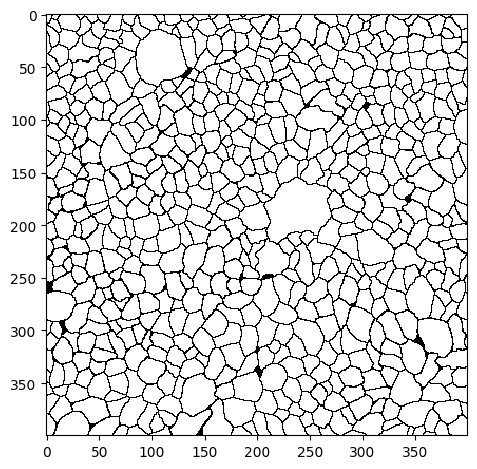

In [16]:
imshow(mask.squeeze().numpy(), cmap="gray")

In [17]:
sam_output = model(image.unsqueeze(0).to(device))

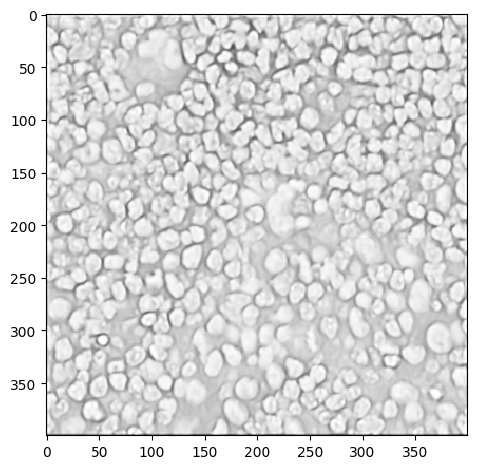

In [18]:
imshow(sam_output.squeeze().detach().cpu().numpy(), cmap="gray")

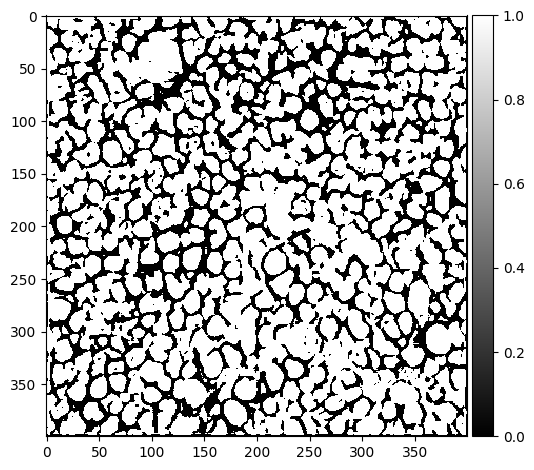

In [36]:
imshow(torch.where(sam_output>0.78, 1, 0).detach().cpu().numpy().squeeze(), cmap="gray")